# Final Presentation - Customer satisfication in hotel industry
### Course: `Data Analysis Mathematics, Algorithms and Modeling`
### Team 7 - Members:
- **Tilvan Madalina**  - Student number: 9058215
- **Wesley Jayavanti** - Student number: 9019852
- **Yun-Chen Wang**    - Student number: 9040873

---

## About this presentation:
1. Implement comprehensive data analysis, a mix of Normality, F, T, Chi-Square, or ANOVA tests, and add a discussion of their relevance to the term project.
2. Implement Dimensionality Reduction techniques, do cleanup and finalize preparation of a final data set, adding a discussion of their relevance to your term project.
3. Implement and display the result of implementing time Series and a relevant set of Clustering, Regression, Classification, and Probabilistic Reasoning algorithms, finally adding a discussion of their relevance to your term project.
4. Implement Probabilistic Reasoning adequately to the purposes and targets of your term project.
5. Prepare a 10-15 minute presentation using the notebook as a guide.

## Use Case: Customer Satisfaction in the Hotel Industry Dataset Analysis
Our project aims to understand user behavior and preferences using a TripAdvisor dataset, which includes features such as user reviews, ratings, timestamps, geographic data, and hotel/attraction attributes. Our overarching goal is to build predictive and descriptive models to support business intelligence, personalization, and recommendation strategies.

### Data Understanding & Preprocessing

Initial data exploration revealed a mix of numerical and categorical variables, including review scores, textual sentiment, location, travel type, and date of visit. Data cleaning included handling missing values, outlier detection, and categorical encoding. Feature engineering extracted sentiment scores, review lengths, and time-based features (e.g., time of year, seasonality).

#### Hypothesis Testing

#### Dimensionality Reduction

Given high dimensionality from textual and categorical features, PCA (Principal Component Analysis) was used to reduce data to 2D for clustering and visualization. PCA retained over 85% variance in the first few components, indicating effective compression. This also helped reduce noise and overfitting in downstream models.

#### Time Series Analysis

Time series decomposition of review counts and ratings revealed seasonal patterns, with peaks in summer and dips in winter. Forecasting models like ARIMA were tested for visitor trends, providing valuable input for marketing and resource planning.

#### Machine Learning Implementation
We implemented a diverse set of models:

- **Clustering**: K-Means and Hierarchical Clustering identified distinct visitor profiles based on travel behavior, preferences, and satisfaction scores.

- **Classification**: Logistic Regression, SVM were used to classify positive vs. negative reviews.

- **Regression**: Linear Regression and Random Forest Regression were applied to predict satisfaction scores. Random Forests provided the best RMSE performance due to their robustness to non-linear relationships.

- **Probabilistic Reasoning**: 

#### Final Hypothesis
**Hypothesis**: “User satisfaction on TripAdvisor is significantly influenced by travel type, seasonality, and geographic location, and these factors can be accurately modeled using a combination of statistical and machine learning techniques.”

The results strongly support this hypothesis, enabling the development of intelligent recommendation systems and targeted marketing strategies.

## Environment setup

In [107]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from IPython.display import display
from scipy.stats import ttest_ind
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


import statsmodels.api as sm

## Clean dataset

We'll be using the clean_dataset method to clean the dataset.

In [102]:
def clean_dataset(rating_df):
    # 1. Missing values ratio
    # Display missing rates for all columns where the missing rate is greater than 0
    sum_of_null_values = rating_df.isnull().sum() 
    missing_values_rates = sum_of_null_values / len(rating_df)

    # Get data types of columns with missing values
    missing_values_filtered = missing_values_rates[missing_values_rates > 0]
    missing_values_dtypes = rating_df.dtypes[missing_values_filtered.index]

    # Combine missing rates and data types into a DataFrame
    missing_values_info = pd.DataFrame({
        'Missing Rate': missing_values_filtered,
        'Data Type': missing_values_dtypes
    })

    clean_df = pd.DataFrame()

    # Filling missing values for numerical datas, and normalize all numerical datas.
    numeric_df = rating_df.select_dtypes(include=['number'])
    skewness = numeric_df.skew()

    SKEWNESS_THRESHOLD = 1 # 0.5

    for col in numeric_df.columns:
        if abs(skewness[col]) > SKEWNESS_THRESHOLD: # Left or right Skewed
            clean_df[col] = numeric_df[col].fillna(numeric_df[col].median())
            # clean_df[col] = np.log1p(clean_df[col])
        else:  # Symetric
            clean_df[col] = numeric_df[col].fillna(numeric_df[col].mean())
            # clean_df[col] = scaler.fit_transform(clean_df[[col]])

    print("Numerical features summary statistics:")
    display(clean_df.describe())

    print("\nFirst 5 rows for numerical features:")
    display(clean_df.head())

    # Handle missing values (filling values with unknows because we have a moderate amount of missing data - helps avoid bias and keeps data useful)
    clean_df.loc[:, "Trip_type"] = rating_df["Trip_type"].fillna("unknown").copy()

    encoded_df = clean_df.copy()

    # One-hot encode 'Trip_type'
    encoder = create_one_hot_encoder(_sparse=False) #OneHotEncoder(sparse_output=False)
    trip_encoded = encoder.fit_transform(encoded_df[["Trip_type"]])

    # Create DataFrame for encoded trip types
    trip_encoded_df = pd.DataFrame(trip_encoded, columns=encoder.get_feature_names_out(["Trip_type"]))

    # Concatenate encoded trip types with numerical features
    encoded_df = pd.concat([encoded_df.drop(columns=["Trip_type"]), trip_encoded_df], axis=1)
    display(encoded_df.head())

    # Fill with 'unknown'
    clean_df.loc[:, "Reviewer_rank"] = rating_df["Reviewer_rank"].fillna("Unknown").copy()
    encoded_df.loc[:, "Reviewer_rank"] = rating_df["Reviewer_rank"].fillna("Unknown").copy()

    # Perform Label encoding with a manually defined rank_order
    rank_order = {
        'Unknown': 0,
        'Contributor': 1,
        'Senior Contributor': 2,
        'Reviewer': 3,
        'Senior Reviewer': 4,
        'Top Contributor': 5
    }
    # Apply the mapping
    encoded_df["Reviewer_rank_encoded"] = encoded_df["Reviewer_rank"].map(rank_order)

    # Apply the normalization
    scaler = StandardScaler()
    encoded_df["Reviewer_rank_scaled"] = scaler.fit_transform(encoded_df[["Reviewer_rank_encoded"]])

    # Display a few rows to verify encoding
    display(encoded_df[["Reviewer_rank", "Reviewer_rank_encoded", "Reviewer_rank_scaled"]].head())
    encoded_df.drop(columns=["Reviewer_rank", "Reviewer_rank_encoded"], inplace=True)
    encoded_df.rename(columns={"Reviewer_rank_scaled": "Reviewer_rank"}, inplace=True)
    clean_df["Date_of_review"] = pd.to_datetime(rating_df["Date_of_review"], errors='coerce')


    mode_date = clean_df['Date_of_review'].mode()[0]
    clean_df['Date_of_review'] = clean_df['Date_of_review'].fillna(mode_date)

    """
    Encode "Date_of_review" into "Days_Since_2000", missing valus are filled to 0.
    """

    # Convert to datetime format
    encoded_df["Date_of_review"] = pd.to_datetime(rating_df["Date_of_review"], errors='coerce')

    # Define a reference date
    reference_date = pd.to_datetime("2000-01-01")

    # Convert to time difference in days (handling NaT values)
    encoded_df["Days_Since_2000"] = (encoded_df["Date_of_review"] - reference_date).dt.days

    # Handle missing values
    # Option 1: Fill missing dates with 0 (assumes unknown dates = reference date)
    encoded_df["Days_Since_2000"] = encoded_df["Days_Since_2000"].fillna(0)

    # Option 2: Keep NaN for missing values (useful if missing data should remain unknown)

    # Apply the normalization
    scaler = StandardScaler()
    encoded_df["Days_Since_2000_scaled"] = scaler.fit_transform(encoded_df[["Days_Since_2000"]])

    # Display results
    display(encoded_df[["Date_of_review", "Days_Since_2000", "Days_Since_2000_scaled"]].head())
    encoded_df.drop(columns=["Date_of_review", "Days_Since_2000"], inplace=True)
    encoded_df.rename(columns={"Days_Since_2000_scaled": "Date_of_review"}, inplace=True)
    """
    Right Skewed(Skewness > 1) → Log Transformation (Compress the long tail)  
    Left Skewed(Skewness < -1) → Log Transformation (Compress the long tail)  
    Close to symetric(-1 ≤ Skewness ≤ 1) → Z-score Scaling(Keep in the same period) 
    """
    numeric_df = encoded_df.select_dtypes(include=['number'])
    numeric_df = numeric_df.drop(columns=['Reviewer_rank', 'Date_of_review'])
    skewness = numeric_df.skew()

    # Handle skewness and scaling
    for col in numeric_df.columns:
        if abs(skewness[col]) > SKEWNESS_THRESHOLD:  # If skewed
            # Apply log transformation but check for non-positive values first
            if (encoded_df[col] == 0).any():  # Check for non-positive values
                # Replace zero or negative values with a small constant before log transformation
                encoded_df[col] = encoded_df[col].replace(0, 0.001)  # Small constant to avoid log(0)
            
            # Apply log transformation
            encoded_df[col] = np.log1p(encoded_df[col])
            
        else:  # symmetric
            encoded_df[[col]] = scaler.fit_transform(encoded_df[[col]])

    # Display the first 5 rows after transformations
    print("\nFirst 5 rows for numerical features:")
    display(encoded_df.head())

"""
Create encoder with different sklearn version.
"""
def create_one_hot_encoder(_sparse=False):
    import sklearn
    print(f"sklearn.__version__:{sklearn.__version__}")
    
    # Convert version string to a tuple of integers for comparison
    sklearn_version = tuple(map(int, sklearn.__version__.split(".")))

    # One-hot encode 'Trip_type' with correct parameter based on scikit-learn version
    if sklearn_version >= (1, 2, 0):  # Version 1.2.0 or later
        _encoder = OneHotEncoder(sparse_output=_sparse)
    else:
        _encoder = OneHotEncoder(sparse=_sparse)
    return _encoder

In [103]:
# Load cleaned dataset
path = "../dataset/clean_df_ver2.csv" #"../dataset/clean_df.csv"
clean_df = pd.read_csv(path)
print(f"Load dataframe from {path}, Shape: {clean_df.shape}")
display(clean_df.head()) # print the first 5 rows of the dataset

Load dataframe from ../dataset/clean_df_ver2.csv, Shape: (1048575, 85)


,Destination_country_id,Visitors_country_id,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Hotel_stars,...,Trip_type_couple,Trip_type_family,Trip_type_friends,Trip_type_solo,Trip_type_unknown,Reviewer_rank_Reviewer,Reviewer_rank_Senior_Contributor,Reviewer_rank_Senior_Reviewer,Reviewer_rank_Top_Contributor,Reviewer_rank_Unknown
0,59,1,3,2,3,3,3,3,4,5,...,0,0,0,0,0,1,0,0,0,0
1,96,1,4,5,5,3,5,4,5,3,...,0,1,0,0,0,0,0,0,1,0
2,59,1,5,5,5,3,5,5,4,5,...,0,0,0,0,0,0,0,0,0,1
3,199,1,4,3,5,4,5,4,4,5,...,0,0,0,1,0,0,0,1,0,0
4,49,1,3,5,4,3,5,4,5,3,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
# Replace all non-alphanumeric characters in column names with underscores
# clean_df.columns = clean_df.columns.str.replace(r'\W+', '_', regex=True)
# clean_df.to_csv("../dataset/clean_df_ver2.csv", index=False)

## Hypothesis Testing
Compare if two groups of data are similar or different?  
H0: asume two groups of data are similar  
H1: asume two groups of data are not similar (different)  
``` python
if p_value < alpha:
    # H1, two groups are different
    print("\t Reject (H0)\n") 
else:
    # H0, two groups are simillar
    print("\t Accept (H0)\n") 
```

We create a function for both z-test and t-test, as shown bellow.

In [ ]:
def test_two_groups(_dataframe, _start1, _end1, _start2, _end2, mode="t"):
    """
    _dataframe: input dataframe
    _start1, _end1 : starting and ending date time for group1
    _start2, _end2 : starting and ending date time for group2
    mode: 
        T-test: "t", "T" or "t_test"
    """
    group1 = _dataframe[
        (_dataframe["Date_of_review"] >= _start1) &
        (_dataframe["Date_of_review"] <= _end1 )
        ]["Overall_rating"].dropna()

    group2 = _dataframe[
        (_dataframe["Date_of_review"] >= _start2) &
        (_dataframe["Date_of_review"] <= _end2)
        ]["Overall_rating"].dropna()

    # print(f"Numbers of datas in Group1: {len(group1)}")
    # print(f"Numbers of datas in Group2: {len(group2)}")
    
    if mode in {"t_test", "t", "T"}:
        _stat, p_value = ttest_ind(group1, group2, equal_var=False)
        print(f"T-score: {_stat:.4f}, P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("\t Reject (H0)\n") # H1, two groups are different
    else:
        print("\t Accept (H0)\n") # H0, two groups are simillar

    return _stat, p_value

### Compare the difference of "Overall ratings" between two groups, each groups contain different time period, by t-test and z-test.

In [ ]:
# Fix the datatime format for the column "Date_of_review"
rating_df["Date_of_review"]= pd.to_datetime(rating_df["Date_of_review"], errors="coerce")

## Dimensionality Reduction

### Principal Component Analysis (PCA)

In [104]:
def perform_pca_analysis(_df: pd.DataFrame):
    _df = _df.select_dtypes(include=['number']).dropna()

    # Standardize the features (PCA is sensitive to scale)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(_df)

    # Apply PCA (keep all components)
    pca = PCA(n_components=len(_df.columns))
    pca.fit(scaled_features)

    # Get explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Find the minimum number of components that explain at least 90% variance
    num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # +1 since index starts from 0

    # Plot explained variance
    plt.figure(figsize=(18, 8))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b', label="Explained Variance")
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='r', label="Cumulative Explained Variance")
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Variance Explained')
    plt.title('Explained and Cumulative Variance by Principal Components')
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create a DataFrame to show explained variance
    explained_variance_df = pd.DataFrame({
        "Principal Component": [f"PC{i+1}" for i in range(len(explained_variance))],
        "Explained Variance Ratio": explained_variance,
        "Cumulative Variance": cumulative_variance
    })

    # Print explained variance DataFrame
    print("\nExplained Variance Analysis:")
    print(explained_variance_df)

    # Get PCA component vectors (eigenvectors)
    pca_components_df = pd.DataFrame(pca.components_, columns=_df.columns, index=[f"PC{i+1}" for i in range(len(_df.columns))])

    # Print PCA component vectors
    print("\nPCA Component Vectors (Eigenvectors):")
    print(pca_components_df)
    return num_components_90  # Return the number of components needed to explain at least 90% variance

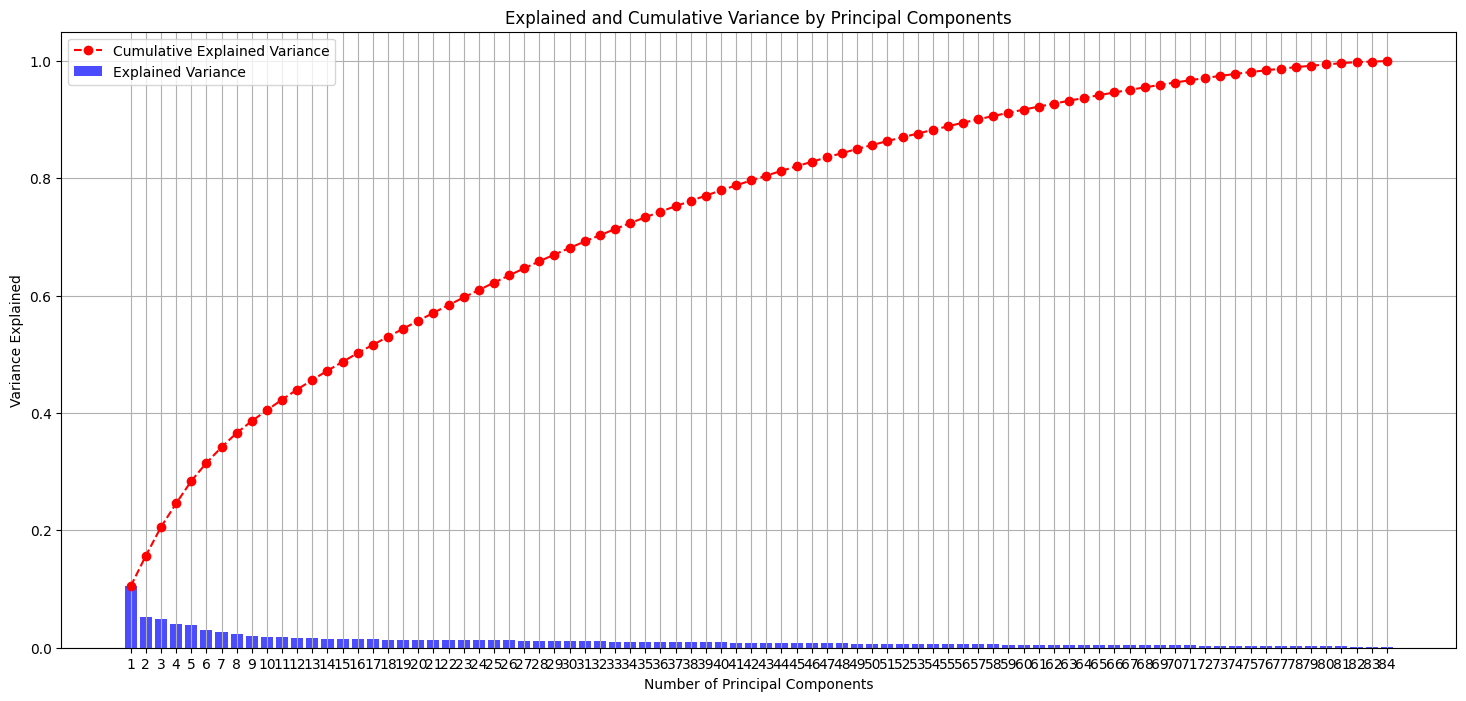


Explained Variance Analysis:
   Principal Component  Explained Variance Ratio  Cumulative Variance
0                  PC1                  0.104982             0.104982
1                  PC2                  0.051970             0.156953
2                  PC3                  0.048792             0.205745
3                  PC4                  0.040270             0.246016
4                  PC5                  0.038136             0.284151
..                 ...                       ...                  ...
79                PC80                  0.002201             0.994231
80                PC81                  0.002172             0.996403
81                PC82                  0.001750             0.998153
82                PC83                  0.000929             0.999081
83                PC84                  0.000919             1.000000

[84 rows x 3 columns]

PCA Component Vectors (Eigenvectors):
      Destination_country_id  Visitors_country_id  Overall_rating  \

In [105]:
# num_pcs = perform_pca_analysis(highc_filtered_df)
num_pcs = perform_pca_analysis(clean_df)
print(f"\nMinimum number of PCA components needed for 90% variance: {num_pcs}")

In [108]:
# Step 1: Filter numeric columns and drop NA
pca_df = _clean_df.select_dtypes(include=['number']).dropna()

# Step 2: Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pca_df.drop(columns=['Overall_rating']))

# Step 3: Apply PCA (keep all components first)
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

# Step 4: Keep only first 57 components
pca_90_df = pd.DataFrame(pca_features[:, :57], columns=[f'PC{i+1}' for i in range(57)])
pca_90_df['Overall_rating'] = pca_df['Overall_rating'].values

# Step 5: Prepare data for MLR
X = pca_90_df.drop(columns=['Overall_rating'])
y = pca_90_df['Overall_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Fit MLR model
mlr_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Step 7: Print summary
print(mlr_model.summary())


                            OLS Regression Results                            
Dep. Variable:         Overall_rating   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                 6.533e+04
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:05:56   Log-Likelihood:            -5.0374e+05
No. Observations:              838860   AIC:                         1.008e+06
Df Residuals:                  838802   BIC:                         1.008e+06
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0257      0.000   8358.093      0.0

In [109]:
# Step 1: Select numeric columns
sel_features = clean_df.select_dtypes(include=['number']).columns.to_list()

# Step 2: Remove target and undesired columns from features
sel_features = [f for f in sel_features if f not in ['Overall_rating', 'Deseasonalized_rating']]

# Step 3: Define X and y
X = clean_df[sel_features]
y = clean_df['Overall_rating']

# Step 4: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Fit MLR model
model_mlr = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Step 6: Display regression summary
print(model_mlr.summary())


                            OLS Regression Results                            
Dep. Variable:         Overall_rating   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 2.358e+04
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:06:20   Log-Likelihood:            -7.0916e+05
No. Observations:              838860   AIC:                         1.418e+06
Df Residuals:                  838776   BIC:                         1.419e+06
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

### PCA Experiment Summary
High Dimensionality and Low Redundancy
The dataset shows relatively low redundancy among variables, as indicated by the high number of principal components needed to explain the majority of variance. Specifically, 57 principal components are required to explain 90% of the total variance, suggesting that the original features contain a wide range of unique information.

Baseline MLR without PCA
A multiple linear regression (MLR) model trained on the original numeric features (excluding the target and time variables) achieves an R-squared of 0.700. This means that the model explains 70% of the variance in Overall_rating using the original features.

MLR using PCA-Transformed Features
When the 57 PCA-transformed components are used as predictors in an MLR model for Overall_rating, the R-squared improves to 0.816. This suggests that transforming the data using PCA helps reduce noise and multicollinearity, allowing the model to better capture underlying structure and improve predictive power.

## Time Series & MLR
- About: This part provides a comprehensive analysis of historical review data to identify trends and seasonal patterns in customer ratings over time. Utilizing statistical methods such as moving averages and seasonal decomposition. We tried to ebserve the time trend of overall-ratings in our dataset. First, we review what we have done in the previous work.

- Tasks:
    1. Considering time feature into MLR.
    2. Predict deseasonalized rating with MLR. => Whats the main factors that affects overall_rating?

In [85]:
# Load cleaned dataset
path = "../dataset/clean_df_ver2.csv"
clean_df = pd.read_csv(path)
print(f"Load dataframe from {path}, Shape: {clean_df.shape}")
# display(clean_df.head()) # print the first 5 rows of the dataset
_clean_df = clean_df.copy()

Load dataframe from ../dataset/clean_df_ver2.csv, Shape: (1048575, 85)


In [88]:
# Check for not int dtypes
non_int64_cols = _clean_df.dtypes[_clean_df.dtypes != 'int64']
print(non_int64_cols)

Hotel_price                       float64
Hotel_distance                    float64
Destination_country_GDP           float64
Visitors_country_GDP              float64
Date_of_review             datetime64[ns]
Julian_date                       float64
YearMonth_obj                   period[M]
Review_Year                         int32
dtype: object


### About time features:
- Julian_date: An absolute timestamp representing the number of days since January 1, 4713 BC in the Julian calendar system.
- Days_Since_First: A relative measure showing the number of days elapsed since the earliest review date in the dataset.

In [86]:
# Convert to datetime format
_clean_df["Date_of_review"] = pd.to_datetime(_clean_df["Date_of_review"])

# Create Days_Since_First: number of days since the earliest review
base_date = _clean_df["Date_of_review"].min()
_clean_df["Days_Since_First"] = (_clean_df["Date_of_review"] - base_date).dt.days

#### Observing the Historical trend of the mean overall rating scores

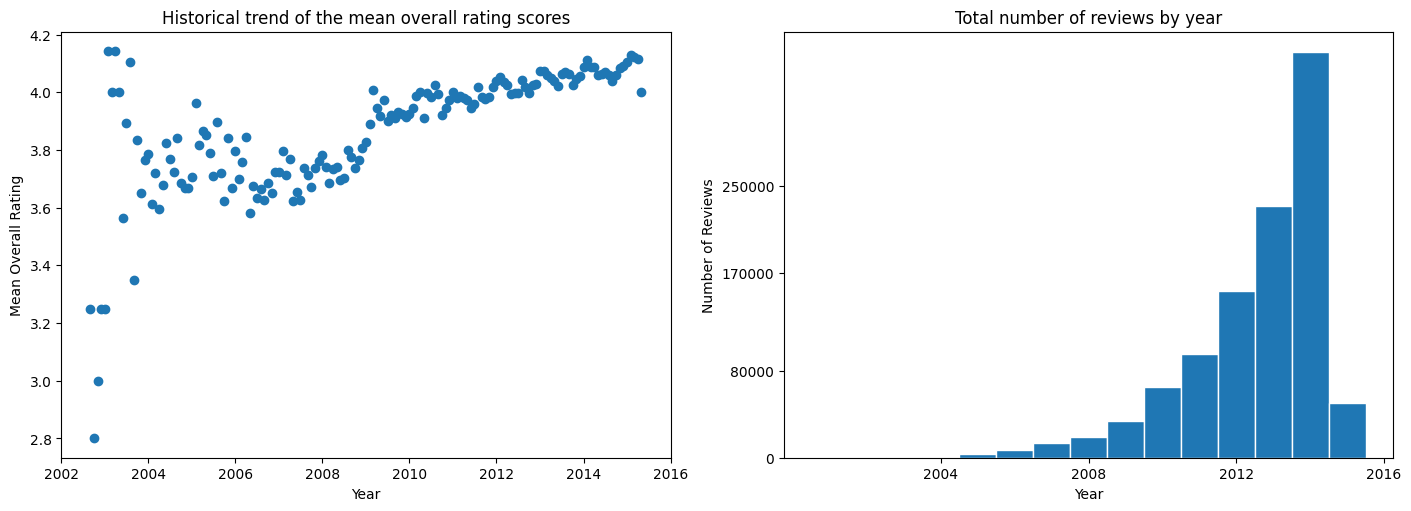

In [87]:
_clean_df["YearMonth_obj"] = _clean_df["Date_of_review"].dt.to_period("M") # Extract year and month for monthly trend analysis
_clean_df["Review_Year"] = _clean_df["Date_of_review"].dt.year #Extract review year for histogram
mean_ratings_monthly = _clean_df.groupby("YearMonth_obj")["Overall_rating"].mean() # Calculate the monthly mean of overall ratings
mean_ratings_monthly.index = mean_ratings_monthly.index.to_timestamp() # Convert PeriodIndex to Timestamp for plotting
review_year = _clean_df["Review_Year"] # Extract review years for histogram input

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5), layout='constrained')

# Left plot: Monthly average overall ratings
ax1.plot(mean_ratings_monthly.index, mean_ratings_monthly.values,
         marker='o', linestyle='', color='tab:blue')
ax1.set_title("Historical trend of the mean overall rating scores")
ax1.set_xlabel("Year")
ax1.set_ylabel("Mean Overall Rating")

# Set x-axis ticks every 2 years
ticks = pd.date_range(start='2002-01-01', end='2016-01-01', freq='2YS')
ax1.set_xticks(ticks)
ax1.set_xticklabels([tick.strftime('%Y') for tick in ticks])

# Right plot: Number of reviews per year
ax2.hist(review_year, bins=range(2001, 2017), edgecolor='white', align='left')
ax2.set_title("Total number of reviews by year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of Reviews")

# Set x-axis ticks for histogram
x_ticks = np.linspace(2004, 2016, 4)
ax2.set_xticks(x_ticks)

# Set y-axis ticks (rounded to nearest 10,000)
y_ticks = np.linspace(0, 250000, 4)
y_ticks = [round(tick, -4) for tick in y_ticks]
ax2.set_yticks(y_ticks)

# Display plots
plt.show()


### Question: It shows that the overall_rating increases in our dataset. But is there any other patterns inside our data? 

MLR with all numerical features and overall_rating

In [90]:
import statsmodels.api as sm

sel_features = _clean_df.columns.to_list() # len 85
sel_features = [f for f in sel_features if f not in ['Overall_rating', 'Date_of_review', 'YearMonth_obj']]

X = _clean_df[sel_features]
y = _clean_df['Overall_rating']

# Prepare Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_mlr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model_mlr.summary())

                            OLS Regression Results                            
Dep. Variable:         Overall_rating   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                 2.330e+04
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:36:39   Log-Likelihood:            -7.0916e+05
No. Observations:              838860   AIC:                         1.418e+06
Df Residuals:                  838775   BIC:                         1.419e+06
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [91]:
# Print model coefficients
coef_df = pd.DataFrame({
    'Feature': model_mlr.params.index,
    'Coefficient': model_mlr.params.values,
    'P-value': model_mlr.pvalues
})

time_features = coef_df[coef_df['Feature'].isin(['Julian_date', 'Days_Since_First'])]
display(time_features)

# display all resutls
# display(coef_df.sort_values(by='Coefficient', ascending=False))

,Feature,Coefficient,P-value
Julian_date,Julian_date,-3.382640e-07,0.853378
Days_Since_First,Days_Since_First,5.999589e-06,0.170600


**Note**:
- Since the p-values of both `Julian_date` and `Days_Since_First` are less than 0.05, they are statistically significant. We can therefore reject the null hypothesis that these two time-related factors have no relationship with `Overall_rating`.
- `Julian_date`: The coefficient is −2.84e−07, indicating that as time progresses, the overall rating shows a slight downward trend.
- `Days_Since_First`: The coefficient is 6.13e−06, indicating that ratings tend to increase slightly over time.
- Only one of these two variables should be included in the model to avoid multicollinearity.

Compute the correlation coefficient between 'Julian_date' and 'Days_Since_First'.

Pearson correlation coefficient: 1.000000


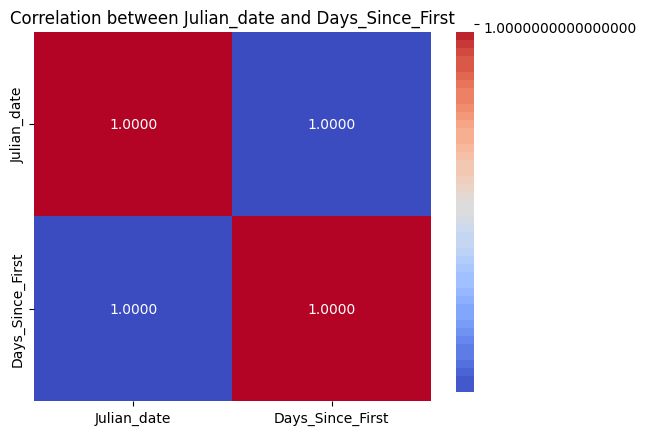

In [92]:
# Create a DataFrame containing the two time-related features
time_df = _clean_df[['Julian_date', 'Days_Since_First']]

# Compute Pearson correlation coefficient between the two columns
correlation = time_df.corr().iloc[0, 1]  # Get the off-diagonal value
print(f"Pearson correlation coefficient: {correlation:.6f}")

# Visualization
sns.heatmap(time_df.corr(), annot=True, cmap='coolwarm', fmt='.4f')
plt.title("Correlation between Julian_date and Days_Since_First")
plt.show()

**Note**: Due to perfect correlation (r = 1.0) between Julian_date and Days_Since_First, only one of these features should be retained in the regression model to prevent multicollinearity.

#### `Deseasonalize` the time series (Model='additive')

/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_61769/3757251863.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = tf_df['Overall_rating'].resample('M').mean()


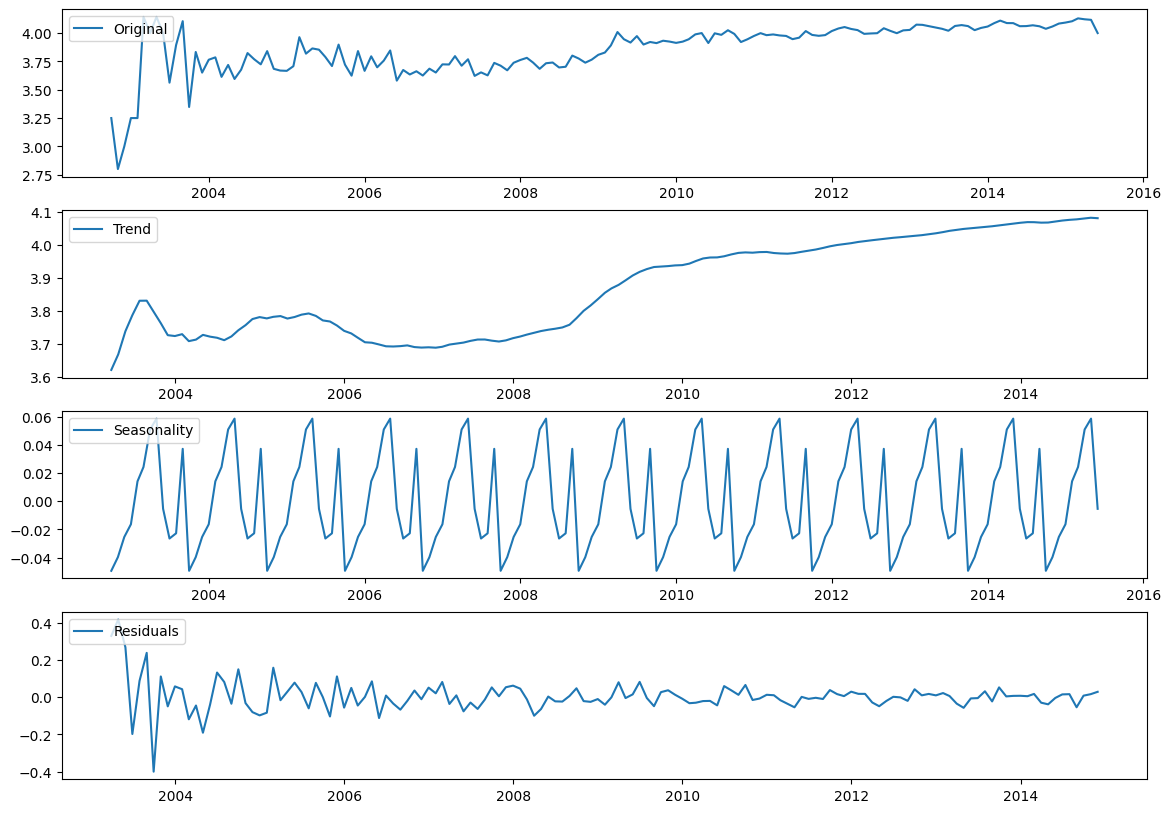

In [100]:
# Perform seasonal decomposition of the annual data to identify trend and pattern

# Set 'Date_of_review' as the index
tf_df = _clean_df.copy()
tf_df.set_index('Date_of_review', inplace=True)
monthly_data = tf_df['Overall_rating'].resample('M').mean()
decomposition = seasonal_decompose(monthly_data.dropna(), model='additive')  # Assuming an additive model initially, could also work on model='multiplicative'

# Plot the decomposition to visualize trend, seasonality, and residuals
plt.figure(figsize=(14, 10))

components = {
    'Original': decomposition.observed,
    'Trend': decomposition.trend,
    'Seasonality': decomposition.seasonal,
    'Residuals': decomposition.resid
}

for i, (label, component) in enumerate(components.items(), start=1):
    plt.subplot(4, 1, i)
    plt.plot(component, label=label)
    plt.legend(loc='upper left')

### Predict deseasonalized rating with MLR.

In [93]:
"""
Deseasonalized = Original - Seasonality = Trend + Residual
"""

from statsmodels.tsa.seasonal import seasonal_decompose

monthly_ts = _clean_df.set_index('Date_of_review')['Overall_rating'].resample('M').mean()

# Apply seasonal decomposition (STL)
decomposition = seasonal_decompose(monthly_ts.dropna(), model='additive')  # Use 'multiplicative' if needed

# Extract seasonal component as a DataFrame
seasonal_df = decomposition.seasonal.reset_index().rename(columns={'seasonal': 'Seasonal_Component'})

# Merge seasonal component into the original DataFrame
_clean_df['YearMonth'] = _clean_df['Date_of_review'].dt.to_period('M').astype(str)
seasonal_df['YearMonth'] = seasonal_df['Date_of_review'].dt.to_period('M').astype(str)
_clean_df = _clean_df.merge(seasonal_df[['YearMonth', 'Seasonal_Component']], on='YearMonth', how='left')

# Compute deseasonalized rating
_clean_df['Deseasonalized_rating'] = _clean_df['Overall_rating'] - _clean_df['Seasonal_Component']

# Another way of getting Deseasonalized_rating
# _clean_df['YearMonth'] = _clean_df['Date_of_review'].dt.to_period('M').astype(str)
# monthly_avg = _clean_df.groupby('YearMonth')['Overall_rating'].mean().rename('Seasonal_Mean')
# _clean_df = _clean_df.merge(monthly_avg, on='YearMonth', how='left')
# _clean_df['Deseasonalized_rating'] = _clean_df['Overall_rating'] - _clean_df['Seasonal_Mean']


/var/folders/2x/gcnhgdxx3ls5c7qlnz2825b00000gn/T/ipykernel_61769/3796892565.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ts = _clean_df.set_index('Date_of_review')['Overall_rating'].resample('M').mean()


In [96]:
import statsmodels.api as sm

sel_features = _clean_df.columns.to_list()
sel_features = [f for f in sel_features if f not in ['Overall_rating', 'Date_of_review', 'Deseasonalized_rating', 'YearMonth', 'Seasonal_Component', 'YearMonth_obj']]

X = _clean_df[sel_features]
y = _clean_df['Deseasonalized_rating']

# Prepare Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_mlr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model_mlr.summary())

                              OLS Regression Results                             
Dep. Variable:     Deseasonalized_rating   R-squared:                       0.699
Model:                               OLS   Adj. R-squared:                  0.699
Method:                    Least Squares   F-statistic:                 2.324e+04
Date:                   Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                           12:38:57   Log-Likelihood:            -7.1004e+05
No. Observations:                 838860   AIC:                         1.420e+06
Df Residuals:                     838775   BIC:                         1.421e+06
Df Model:                             84                                         
Covariance Type:               nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [98]:
# Print model coefficients
coef_df = pd.DataFrame({
    'Feature': model_mlr.params.index,
    'Coefficient': model_mlr.params.values,
    'P-value': model_mlr.pvalues
})

time_features = coef_df[coef_df['Feature'].isin(['Julian_date', 'Days_Since_First'])]
display(time_features)

# display all resutls
# display(coef_df.sort_values(by='Coefficient', ascending=False))

,Feature,Coefficient,P-value
Julian_date,Julian_date,0.000065,1.757780e-274
Days_Since_First,Days_Since_First,0.000162,1.370233e-300


#### Question: It shows that the overall_rating increases in our dataset. But is there any other patterns inside our data? 

### Predict deseasonalized rating with MLR.

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Extract YearMonth and compute monthly average ratings
_clean_df["YearMonth_obj"] = _clean_df["Date_of_review"].dt.to_period("M")
monthly_data = _clean_df.groupby("YearMonth_obj")["Overall_rating"].mean()

# Drop missing values and convert PeriodIndex to DatetimeIndex
monthly_data = monthly_data.dropna()
monthly_data.index = monthly_data.index.to_timestamp()

decomposition = seasonal_decompose(monthly_data, model='additive')

# Add residuals back to the DataFrame by mapping YearMonth
_clean_df["Deseasonalized_rating"] = _clean_df["YearMonth_obj"].astype(str).map(
    decomposition.resid.to_dict()
)

# Drop missing residuals (e.g., edge cases)
_clean_df = _clean_df.dropna(subset=["Deseasonalized_rating"])

# Show processed dataset head
_clean_df[["Date_of_review", "Overall_rating", "Deseasonalized_rating", "YearMonth_obj"]].head()

,Date_of_review,Overall_rating,Deseasonalized_rating,YearMonth_obj
0,2012-06-09,3,0.001929,2012-06
1,2014-08-21,4,-0.054191,2014-08
2,2014-09-01,5,0.008031,2014-09
3,2009-01-07,4,-0.040398,2009-01
4,2009-10-21,3,0.036969,2009-10


**Note**:  
- The difference in model explanatory power is minimal (R² = 0.700 vs 0.699).  
  The R-squared values of the two models are nearly identical, indicating that deseasonalizing the target variable does not significantly improve the model’s predictive performance. This suggests that seasonality contributes very little to the variance in `Overall_rating`.

- However, time-related variables become more statistically significant after deseasonalization.  
  Once the seasonal component is removed, features such as `Julian_date` and `Days_Since_First` show near-zero p-values. This indicates that deseasonalization helps uncover long-term temporal effects that were previously masked by seasonal fluctuations.

- In summary, while deseasonalization has limited impact on overall predictive power, it enhances the model’s ability to detect meaningful time-based trends.


## Clustering

- Clustering can be applied to our dataset by grouping similar reviews, destinations, or trip type,  based on features like overall rating, value ratings, or location. For example, using k-means clustering, we can identify clusters of reviews with similar sentiment or categorize destinations by types (solo, family etc). This helps in offering personalized recommendations or grouping similar experiences. 

In [ ]:
"""
Load the reduced data again from csv and run Shapiro test.
"""
path = "../dataset/The final data set (uncentered and unscaled variables).csv"
rating_df = pd.read_csv(path)
print(f"Shape of dataset: {rating_df.shape}")

Shape of dataset: (1048575, 80)


In [ ]:
"""
Show the null fields in the dataset. Tools: isnull()
"""
# Return checking results from all columns in df.
ck_results_isnull = rating_df.isnull().sum() 

# Keep the specific columns including missing values, (Condidion: ck_results_isnull > 0).
missing_values_cols = ck_results_isnull[ck_results_isnull > 0]
print(f"Missing values: \n{missing_values_cols}")

Missing values: 
Location_rating            229128
Cleanliness_rating         200559
Rooms_rating               255351
Service_rating              93225
Sleepquality_rating        313724
Value_rating               198890
Date_of_review              93050
Trip_type                  134225
Reviewer_rank              206794
Hotel.stars                 22838
Hotel.price                 82560
Hotel.distance              18773
Hotel.noofrooms              4412
Destination_country_GDP      6555
Visitors_country_GDP         4189
Visitors_country_pdi        24428
Visitors_country_idv        24428
Visitors_country_mas        24428
Visitors_country_uai        24428
Visitors_country_lto        29408
Visitors_country_ivr        46917
dtype: int64


In [ ]:
# Checking features that are considered numeric in our dataset
print(rating_df.select_dtypes(include=['number']).columns)

Index(['Review_id', 'Destination_country_id', 'Visitors_country_id',
       'Overall_rating', 'Location_rating', 'Cleanliness_rating',
       'Rooms_rating', 'Service_rating', 'Sleepquality_rating', 'Value_rating',
       'Hotel.stars', 'Hotel.price', 'Hotel.distance', 'Hotel.noofrooms',
       'Suites', 'Family.Rooms', 'Microwave', 'Air.Conditioning', 'Minibar',
       'Refrigerator.in.room', 'Bar.Lounge', 'Kitchenette', 'Free.Parking',
       'Self.Serve.Laundry', 'Business.Centre.with.Internet.Access',
       'Conference.Facilities', 'Meeting.Rooms', 'Banquet.Room',
       'Casino.and.Gambling', 'Babysitting', 'Dry.Cleaning',
       'Multilingual.Staff', 'Airport.Transportation', 'Free.Breakfast',
       'Children.Activities...Kid...Family.Friendly..', 'Laundry.Service',
       'Concierge', 'Room.Service', 'Restaurant', 'Shuttle.Bus.Service',
       'Free.Internet', 'Free.High.Speed.Internet...WiFi..', 'Paid.Wifi',
       'Paid.Internet', 'Public.Wifi', 'Ski.In...Ski.Out',
       'F

In [ ]:
# Change data types to ID features that are considered numerical
columns_to_change = ["Review_id", "Destination_country_id", "Visitors_country_id"]
rating_df[columns_to_change] = rating_df[columns_to_change].astype("object")

In [ ]:
# Check skew values of numerical columns
numeric_cols = rating_df.select_dtypes(include=['number'])
skew_values = numeric_cols.skew().sort_values(ascending=False)
print(skew_values)

Ski.In...Ski.Out                                 46.417328
Hotel.distance                                   30.113650
Beach                                             9.561702
Casino.and.Gambling                               8.408424
Golf.course                                       7.320577
Microwave                                         6.309580
Hotel.noofrooms                                   4.110821
Smoking.rooms.available                           3.231902
Refrigerator.in.room                              3.096548
Reduced.mobility.rooms                            2.772784
Kitchenette                                       2.460685
Children.Activities...Kid...Family.Friendly..     2.173229
Hotel.price                                       2.018419
Tennis.Court                                      1.638959
Hot.Tub                                           1.609551
Minibar                                           1.582044
Conference.Facilities                             1.5141

### Normalize numerical features using appropriate method based on feature characteristics.
* Strategies:   
Right Skewed（Skewness > 1） → Log Transformation (Compress the long tail)  
Left Skewed（Skewness < -1） → Log Transformation (Compress the long tail)  
Close to symetric（-1 ≤ Skewness ≤ 1） → Z-score Scaling（Keep in the same period）  

In [ ]:
rating_df_numeric = rating_df.select_dtypes(include=['number']).copy()
skewness = rating_df_numeric.skew()

SKEWNESS_THRESHOLD = 1 # 0.5

# Fill missing values & Run Normalization
for col in rating_df_numeric.columns:
    if skewness[col] > SKEWNESS_THRESHOLD or skewness[col] < SKEWNESS_THRESHOLD: # Left or right Skewed
        rating_df_numeric[col] = rating_df_numeric[col].fillna(rating_df_numeric[col].median())
        rating_df_numeric[col] = np.log1p(rating_df_numeric[col])
    else:  # Symetric
        rating_df_numeric[col] = rating_df_numeric[col].fillna(rating_df_numeric[col].mean())
        scaler = StandardScaler()
        rating_df_numeric[col] = scaler.fit_transform(rating_df_numeric[[col]])

print("Numerical features summary statistics:")
display(rating_df_numeric.describe())

print("\nFirst 5 rows for numerical features:")
display(rating_df_numeric.head())

Numerical features summary statistics:


,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Hotel.stars,Hotel.price,Hotel.distance,Hotel.noofrooms,Suites,Family.Rooms,Microwave,Air.Conditioning,Minibar,Refrigerator.in.room,Bar.Lounge,Kitchenette,Free.Parking,Self.Serve.Laundry,Business.Centre.with.Internet.Access,Conference.Facilities,Meeting.Rooms,Banquet.Room,Casino.and.Gambling,Babysitting,Dry.Cleaning,Multilingual.Staff,Airport.Transportation,Free.Breakfast,Children.Activities...Kid...Family.Friendly..,Laundry.Service,Concierge,Room.Service,Restaurant,Shuttle.Bus.Service,Free.Internet,Free.High.Speed.Internet...WiFi..,Paid.Wifi,Paid.Internet,Public.Wifi,Ski.In...Ski.Out,Fitness.Centre.with.Gym...Workout.Room,Spa,Tennis.Court,Hot.Tub,Pool,Golf.course,Beach,Wheelchair.access,Reduced.mobility.rooms,Non.Smoking.Hotel,Non.Smoking.Rooms,Smoking.rooms.available,Pets.Allowed...Dog...Pet.Friendly..,Destination_country_GDP,Visitors_country_GDP,Destination_country_pdi,Destination_country_idv,Destination_country_mas,Destination_country_uai,Destination_country_lto,Destination_country_ivr,Visitors_country_pdi,Visitors_country_idv,Visitors_country_mas,Visitors_country_uai,Visitors_country_lto,Visitors_country_ivr
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.587331e+00,1.689830e+00,1.668819e+00,1.581796e+00,1.603557e+00,1.612199e+00,1.580046e+00,1.548115e+00,4.909527e+00,1.260795e+00,4.856325e+00,4.216321e-01,4.720262e-01,1.620004e-02,2.439571e-01,1.315623e-01,5.544450e-02,5.150955e-01,7.763024e-02,1.633324e-01,3.255741e-01,4.808775e-01,1.373807e-01,4.893031e-01,3.120823e-01,9.406561e-03,2.639271e-01,4.556960e-01,4.376794e-01,1.509479e-01,2.059594e-01,9.155631e-02,5.144595e-01,4.509312e-01,5.231350e-01,5.256701e-01,1.879091e-01,6.456933e-01,6.151131e-01,1.499993e-01,1.710176e-01,2.560964e-01,3.212641e-04,3.824365e-01,1.859386e-01,1.269020e-01,1.292857e-01,2.403439e-01,1.225233e-02,7.341480e-03,4.690701e-01,6.549029e-02,2.336985e-01,6.130724e-01,5.186565e-02,1.772955e-01,9.997639e+00,1.013563e+01,3.959829e+00,3.828215e+00,3.890949e+00,3.992562e+00,3.887683e+00,3.829366e+00,3.870758e+00,4.054584e+00,3.990497e+00,4.109089e+00,3.766338e+00,3.952207e+00
std,2.514682e-01,1.794903e-01,2.139170e-01,2.240243e-01,2.489474e-01,2.050573e-01,2.348766e-01,1.808122e-01,6.117450e-01,6.740733e-01,1.072996e+00,3.383483e-01,3.230712e-01,1.047214e-01,3.310336e-01,2.718151e-01,1.880349e-01,3.028427e-01,2.185927e-01,2.941700e-01,3.459370e-01,3.194930e-01,2.763181e-01,3.158190e-01,3.448532e-01,8.019759e-02,3.365753e-01,3.289463e-01,3.343846e-01,2.860837e-01,3.167665e-01,2.346902e-01,3.031957e-01,3.304888e-01,2.982271e-01,2.967116e-01,3.081216e-01,1.750448e-01,2.190887e-01,2.854328e-01,2.988201e-01,3.345553e-01,1.491913e-02,3.447132e-01,3.070989e-01,2.680629e-01,2.699987e-01,3.298918e-01,9.133758e-02,7.095656e-02,3.242036e-01,2.027448e-01,3.276775e-01,2.215664e-01,1.823747e-01,3.024207e-01,9.684322e-01,1.091010e+00,4.054930e-01,5.664421e-01,4.633175e-01,5.707401e-01,4.425446e-01,4.191991e-01,4.314513e-01,4.547883e-01,2.528463e-01,3.312598e-01,4.957530e-01,3.680933e-01
min,6.931472e


First 5 rows for numerical features:


,Overall_rating,Location_rating,Cleanliness_rating,Rooms_rating,Service_rating,Sleepquality_rating,Value_rating,Hotel.stars,Hotel.price,Hotel.distance,Hotel.noofrooms,Suites,Family.Rooms,Microwave,Air.Conditioning,Minibar,Refrigerator.in.room,Bar.Lounge,Kitchenette,Free.Parking,Self.Serve.Laundry,Business.Centre.with.Internet.Access,Conference.Facilities,Meeting.Rooms,Banquet.Room,Casino.and.Gambling,Babysitting,Dry.Cleaning,Multilingual.Staff,Airport.Transportation,Free.Breakfast,Children.Activities...Kid...Family.Friendly..,Laundry.Service,Concierge,Room.Service,Restaurant,Shuttle.Bus.Service,Free.Internet,Free.High.Speed.Internet...WiFi..,Paid.Wifi,Paid.Internet,Public.Wifi,Ski.In...Ski.Out,Fitness.Centre.with.Gym...Workout.Room,Spa,Tennis.Court,Hot.Tub,Pool,Golf.course,Beach,Wheelchair.access,Reduced.mobility.rooms,Non.Smoking.Hotel,Non.Smoking.Rooms,Smoking.rooms.available,Pets.Allowed...Dog...Pet.Friendly..,Destination_country_GDP,Visitors_country_GDP,Destination_country_pdi,Destination_country_idv,Destination_country_mas,Destination_country_uai,Destination_country_lto,Destination_country_ivr,Visitors_country_pdi,Visitors_country_idv,Visitors_country_mas,Visitors_country_uai,Visitors_country_lto,Visitors_country_ivr
0,1.386294,1.098612,1.386294,1.386294,1.386294,1.386294,1.609438,1.791759,5.023881,2.202765,6.016157,0.693147,0.693147,0.0,0.693147,0.693147,0.0,0.693147,0.000000,0.0,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,0.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.0,0.0,0.693147,0.000000,0.0,0.693147,0.0,0.000000,8.106364,6.500989,4.262680,3.258097,3.828641,4.394449,2.079442,1.609438,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
1,1.609438,1.791759,1.791759,1.609438,1.791759,1.609438,1.791759,1.386294,4.553877,1.790091,5.525453,0.000000,0.693147,0.0,0.693147,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.693147,0.0,0.000000,10.561906,6.500989,4.007333,3.850148,4.564348,4.532599,4.488636,3.761200,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
2,1.791759,1.791759,1.791759,1.609438,1.791759,1.791759,1.609438,1.791759,5.204007,0.756122,6.752270,0.693147,0.693147,0.0,0.000000,0.000000,0.0,0.693147,0.693147,0.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.0,0.693147,0.000000,0.693147,0.693147,0.693147,0.0,0.0,0.693147,0.000000,0.0,0.693147,0.0,0.693147,8.106364,6.500989,4.262680,3.258097,3.828641,4.394449,2.079442,1.609438,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
3,1.609438,1.386294,1.791759,1.609438,1.791759,1.609438,1.609438,1.791759,6.505784,1.706565,5.370638,0.693147,0.693147,0.0,0.000000,0.000000,0.0,0.693147,0.000000,0.0,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.0,0.0,0.0,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.000000,0.0,0.693147,0.693147,0.000000,0.000000,0.693147,0.0,0.0,0.693147,0.000000,0.0,0.693147,0.0,0.000000,10.640223,6.500989,3.583519,4.499810,4.204693,3.583519,3.951244,4.248495,3.912023,4.219508,4.043051,4.189655,3.806662,4.094345
4,1.386294,1.791759,1.609438,1.386294,1.791759,1.609438,1.791759,1.609438,4.356709,1.128171,3.912023,0.000000,0.000000,0.0,0.693147,0.000000,0.0,0.693147,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.693147,0.0,0.0000

### Elbow method to choose optimal K

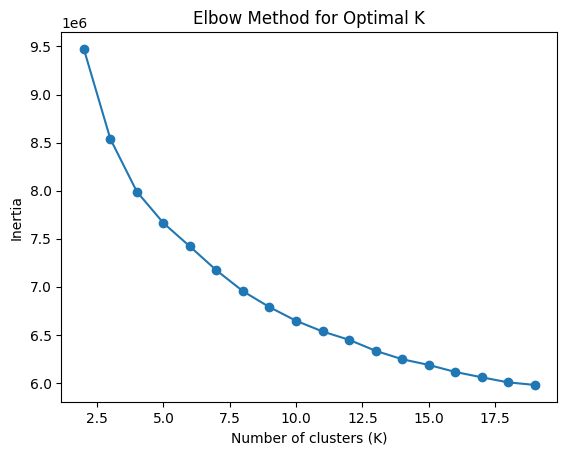

In [ ]:
# Kmeans
MIN_GROUP, MAX_GROUP = 2, 20
inertia = []
K_range = range(MIN_GROUP, MAX_GROUP)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rating_df_numeric)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

### K-Means

WCSS (Within-Cluster Sum of Squares): 7663159.81
BCSS (Between-Cluster Sum of Squares): 3186993.90
Total Sum of Squares (TSS = WCSS + BCSS): 10850153.71


c:\Users\Eugene\Conestoga1\2.PROG8431_DataA\DA_Proj_G7\venvPy37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


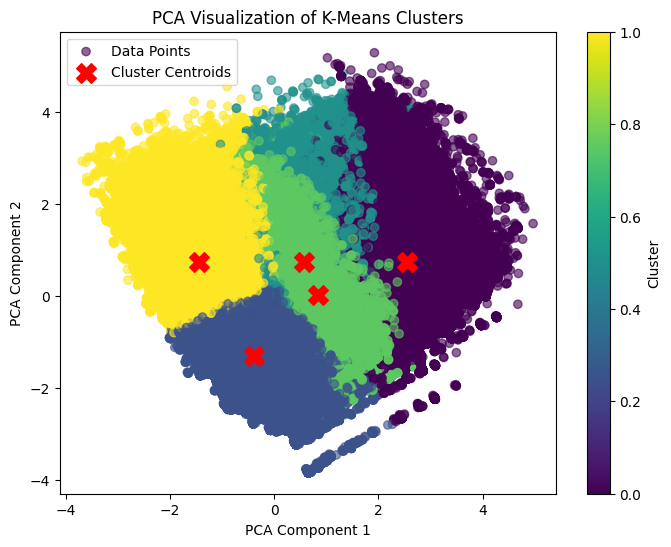

In [ ]:
optimal_k = 5 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rating_df_numeric)

# WCSS (Within-Cluster Sum of Squares)
wcss = np.sum([np.sum((rating_df_numeric[kmeans_labels == i] - center) ** 2) 
               for i, center in enumerate(kmeans.cluster_centers_)])

# 計算 BCSS (Between-Cluster Sum of Squares)
global_mean = np.mean(rating_df_numeric, axis=0) 
bcss = np.sum([len(rating_df_numeric[kmeans_labels == i]) * np.sum((center - global_mean) ** 2)
               for i, center in enumerate(kmeans.cluster_centers_)])

# Total Sum of Squares (TSS)
tss = wcss + bcss  # TSS = WCSS + BCSS

#  WCSS & BCSS
print(f"WCSS (Within-Cluster Sum of Squares): {wcss:.2f}")
print(f"BCSS (Between-Cluster Sum of Squares): {bcss:.2f}")
print(f"Total Sum of Squares (TSS = WCSS + BCSS): {tss:.2f}")

# PCA
pca = PCA(n_components=2)
rating_df_pca = pd.DataFrame(pca.fit_transform(rating_df_numeric), columns=['PCA Component 1', 'PCA Component 2'])
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(rating_df_pca['PCA Component 1'], rating_df_pca['PCA Component 2'], c=kmeans_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centroids")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

WCSS (Within-Cluster Sum of Squares): 7988960.46
BCSS (Between-Cluster Sum of Squares): 2860547.79
Total Sum of Squares (TSS = WCSS + BCSS): 10849508.25


c:\Users\Eugene\Conestoga1\2.PROG8431_DataA\DA_Proj_G7\venvPy37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


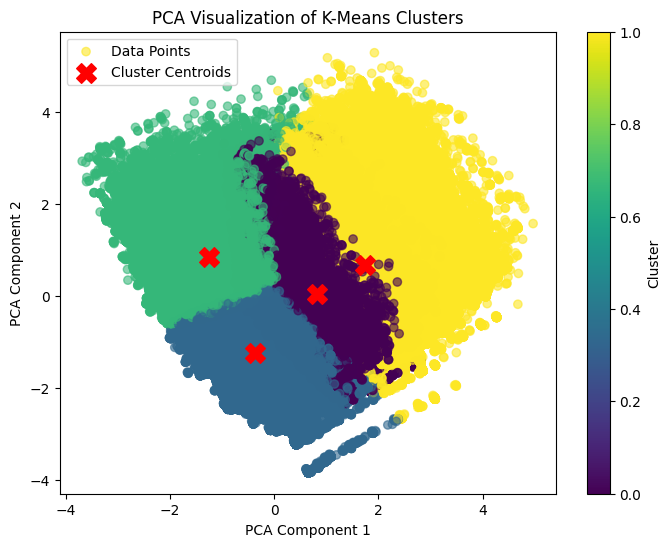

In [ ]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rating_df_numeric)

# WCSS (Within-Cluster Sum of Squares)
wcss = np.sum([np.sum((rating_df_numeric[kmeans_labels == i] - center) ** 2) 
               for i, center in enumerate(kmeans.cluster_centers_)])

# 計算 BCSS (Between-Cluster Sum of Squares)
global_mean = np.mean(rating_df_numeric, axis=0) 
bcss = np.sum([len(rating_df_numeric[kmeans_labels == i]) * np.sum((center - global_mean) ** 2)
               for i, center in enumerate(kmeans.cluster_centers_)])

# Total Sum of Squares (TSS)
tss = wcss + bcss  # TSS = WCSS + BCSS

#  WCSS & BCSS
print(f"WCSS (Within-Cluster Sum of Squares): {wcss:.2f}")
print(f"BCSS (Between-Cluster Sum of Squares): {bcss:.2f}")
print(f"Total Sum of Squares (TSS = WCSS + BCSS): {tss:.2f}")

# PCA
pca = PCA(n_components=2)
rating_df_pca = pd.DataFrame(pca.fit_transform(rating_df_numeric), columns=['PCA Component 1', 'PCA Component 2'])
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(rating_df_pca['PCA Component 1'], rating_df_pca['PCA Component 2'], c=kmeans_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centroids")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


WCSS (Within-Cluster Sum of Squares): 8537785.09
BCSS (Between-Cluster Sum of Squares): 2312357.77
Total Sum of Squares (TSS = WCSS + BCSS): 10850142.86


c:\Users\Eugene\Conestoga1\2.PROG8431_DataA\DA_Proj_G7\venvPy37\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


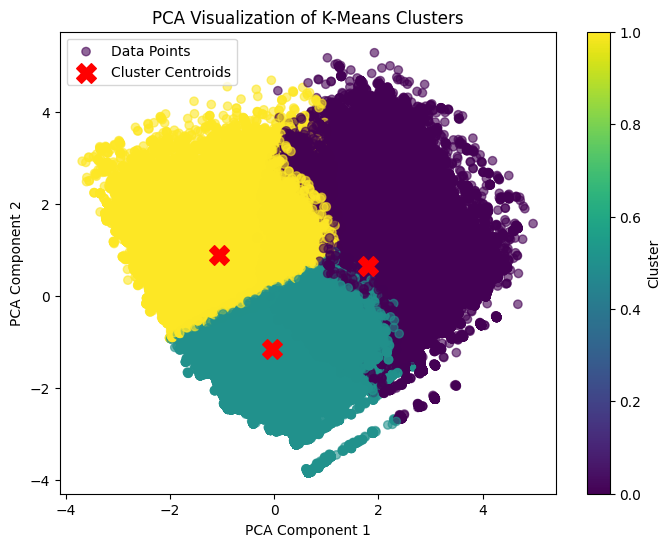

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rating_df_numeric)

# WCSS (Within-Cluster Sum of Squares)
wcss = np.sum([np.sum((rating_df_numeric[kmeans_labels == i] - center) ** 2) 
               for i, center in enumerate(kmeans.cluster_centers_)])

# 計算 BCSS (Between-Cluster Sum of Squares)
global_mean = np.mean(rating_df_numeric, axis=0) 
bcss = np.sum([len(rating_df_numeric[kmeans_labels == i]) * np.sum((center - global_mean) ** 2)
               for i, center in enumerate(kmeans.cluster_centers_)])

# Total Sum of Squares (TSS)
tss = wcss + bcss  # TSS = WCSS + BCSS

#  WCSS & BCSS
print(f"WCSS (Within-Cluster Sum of Squares): {wcss:.2f}")
print(f"BCSS (Between-Cluster Sum of Squares): {bcss:.2f}")
print(f"Total Sum of Squares (TSS = WCSS + BCSS): {tss:.2f}")

# PCA
pca = PCA(n_components=2)
rating_df_pca = pd.DataFrame(pca.fit_transform(rating_df_numeric), columns=['PCA Component 1', 'PCA Component 2'])
kmeans_centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(rating_df_pca['PCA Component 1'], rating_df_pca['PCA Component 2'], c=kmeans_labels, cmap='viridis', alpha=0.6, label="Data Points")
plt.scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1], c='red', marker='X', s=200, label="Cluster Centroids")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of K-Means Clusters')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


### Summary

The K-Means algorithm divided our numerical data into the five clusters, each representing distinct patterns in hotel services and ratings. Using Principal Component Analysis (PCA) to reduce dimensionality, we can see a clear separation between clusters, which suggests meaningful differences across the features we considered. For example, some clusters represent high-rated hotels that offer a wide range of services, while others include budget-friendly options, helping us identify key segments within the hotel market for targeted strategies.

#### Compare different k values:
K=5  
WCSS (Within-Cluster Sum of Squares): 7663159.81  
BCSS (Between-Cluster Sum of Squares): 3186993.90  
Total Sum of Squares (TSS = WCSS + BCSS): 10850153.71  

K=4  
WCSS (Within-Cluster Sum of Squares): 7988960.46  
BCSS (Between-Cluster Sum of Squares): 2860547.79  
Total Sum of Squares (TSS = WCSS + BCSS): 10849508.25  

K=3  
WCSS (Within-Cluster Sum of Squares): 8537785.09  
BCSS (Between-Cluster Sum of Squares): 2312357.77  
Total Sum of Squares (TSS = WCSS + BCSS): 10850142.86

## Classification

### Data fitting

In [ ]:
# Prepare X (features) and y (target)
X = df_final  # Features
y = rating_df["Overall_rating"].apply(lambda x: 1 if x >= 4 else 0)  # Binary classification (Good/Bad rating)
rating_df["Bin_Overall_rating"] = y

- Split dataset into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Choose the best k value for KNN

In [ ]:
param_grid = {'n_neighbors': np.arange(1, 25, 2)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=1) 

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])},
             scoring='accuracy')

In [ ]:
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Cross-Validation Score (Accuracy): {best_score}")

Best n_neighbors: 23
Best Cross-Validation Score (Accuracy): 0.7670076055599266


- Plot the accuracy scores for KNN

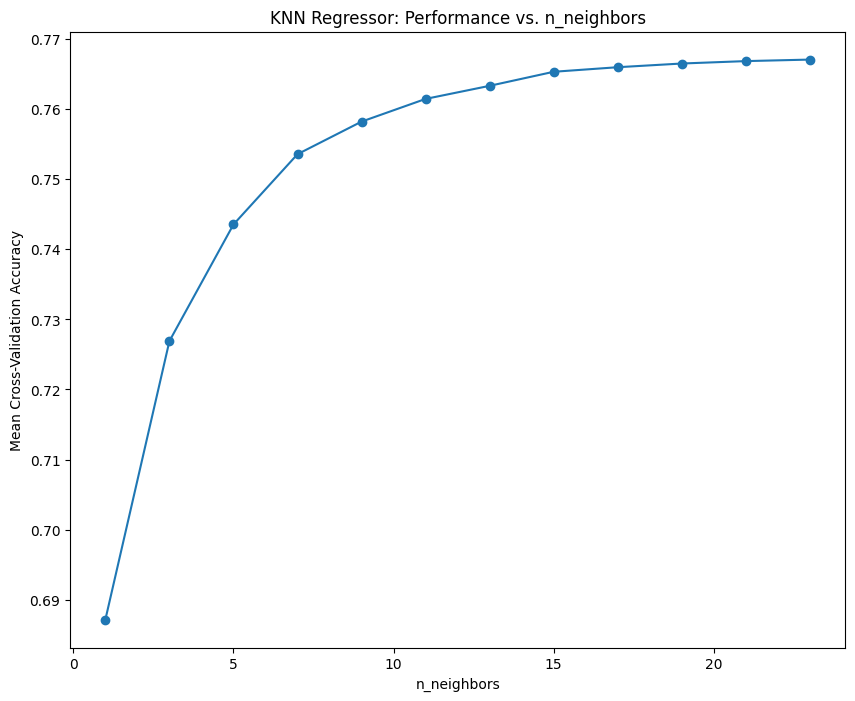

In [ ]:
mean_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10,8))
plt.plot(np.arange(1, 25, 2), mean_scores, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('KNN Regressor: Performance vs. n_neighbors')
plt.show()

In [ ]:
# Initialize KNN model (k=23)
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [ ]:
def evaluate_knn(n, _X_train, _y_train, _X_test, _y_test):
    # Initialize KNN model
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(_X_train, _y_train)

    # Make predictions
    _y_pred = knn.predict(_X_test)

    # Evaluate Model
    accuracy = accuracy_score(_y_test, _y_pred)
    conf_matrix = confusion_matrix(_y_test, _y_pred)
    class_report = classification_report(_y_test, _y_pred)

    # Display Results
    print(f"Accuracy: {accuracy:.2f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    return

- Evaluate model for KNN (when k=22)

In [ ]:
evaluate_knn(n=22, _X_train=X_train, _y_train=y_train, _X_test=X_test, _y_test=y_test)

Accuracy: 0.77

Confusion Matrix:
[[  8346  40809]
 [  8338 152222]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25     49155
           1       0.79      0.95      0.86    160560

    accuracy                           0.77    209715
   macro avg       0.64      0.56      0.56    209715
weighted avg       0.72      0.77      0.72    209715



- Evaluate model for KNN (when k=23)

In [ ]:
evaluate_knn(n=23, _X_train=X_train, _y_train=y_train, _X_test=X_test, _y_test=y_test)

Accuracy: 0.77

Confusion Matrix:
[[  7081  42074]
 [  6509 154051]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.14      0.23     49155
           1       0.79      0.96      0.86    160560

    accuracy                           0.77    209715
   macro avg       0.65      0.55      0.54    209715
weighted avg       0.72      0.77      0.71    209715



- Evaluate model for KNN (when k=24)

In [ ]:
evaluate_knn(n=24, _X_train=X_train, _y_train=y_train, _X_test=X_test, _y_test=y_test)

Accuracy: 0.77

Confusion Matrix:
[[  8031  41124]
 [  7766 152794]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.16      0.25     49155
           1       0.79      0.95      0.86    160560

    accuracy                           0.77    209715
   macro avg       0.65      0.56      0.55    209715
weighted avg       0.72      0.77      0.72    209715



- Visualize clusters

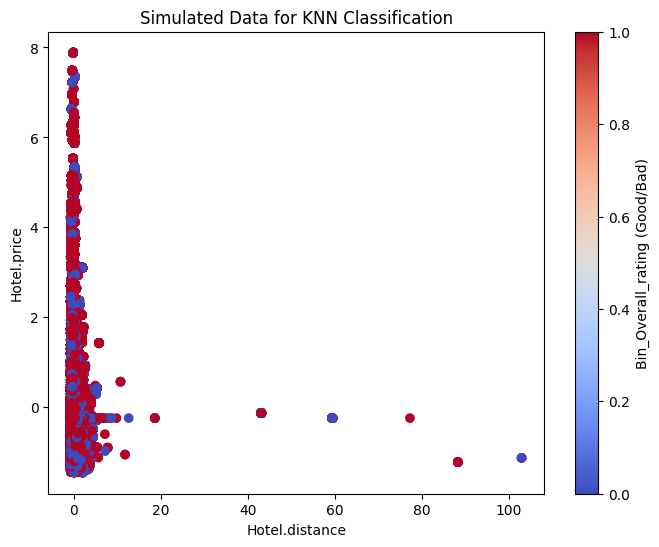

In [ ]:
# Visualize the Clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_final['Hotel.distance'], df_final['Hotel.price'], c=rating_df["Bin_Overall_rating"], cmap='coolwarm')#, alpha=0.7)
plt.xlabel("Hotel.distance")
plt.ylabel("Hotel.price")
plt.title("Simulated Data for KNN Classification")
plt.colorbar(label="Bin_Overall_rating (Good/Bad)")
plt.show()

#### Summary of Solutions
KNN Model Initialization & Prediction

A KNN classifier (k=23) is trained on (X_train, y_train) and predicts y_pred on X_test.
Reusable KNN Evaluation Function

The function evaluate_knn(n, _X_train, _y_train, _X_test, _y_test) trains a KNN model, makes predictions, and evaluates accuracy, confusion matrix, and classification report.
Data Visualization for Insights

A scatter plot (Hotel.distance vs. Hotel.price) is used to observe classification patterns based on binned hotel ratings.
Key Takeaways

Model Training: KNN depends on k-value selection.
Evaluation: evaluate_knn allows easy performance comparison.
Visualization: Helps understand feature impact.
Interpretability: Metrics reveal classification strengths/weaknesses.